In [36]:
import pandas as pd
import numpy as np
from pathlib import Path
import os



In [37]:
Path.cwd()

PosixPath('/tf/animal_clasificacion')

In [38]:

project_folder = "animal_clasificacion" 
if os.getcwd().endswith("/tf"):
    os.chdir(project_folder)

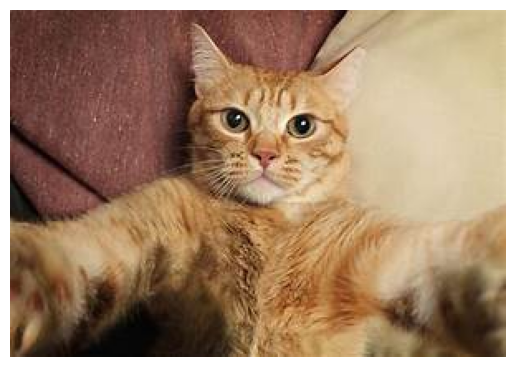

In [39]:
import matplotlib.pyplot as plt
from PIL import Image


# importando la imágen a array

img = Image.open('raw-img/gatto/1.jpeg')


# Representando con matplotlib
def mostrar_imagen(imagen):
    plt.imshow(imagen, cmap='gray')
    plt.axis('off')
    plt.show()
    

mostrar_imagen(img)

In [40]:
BASE_DIR = Path().cwd()

IMG_DIRECTORY = BASE_DIR / 'raw-img'


In [41]:

animales_show = {}

for animal in os.listdir(IMG_DIRECTORY):
    # toma solo la primera imagen encontrada en cada carpeta
    imagenes = list((IMG_DIRECTORY / animal).iterdir())
    if imagenes:
        animales_show[animal] = imagenes[0]

In [42]:
print(animales_show['gatto'])         
print(type(animales_show['gatto']))


/tf/animal_clasificacion/raw-img/gatto/1029.jpeg
<class 'pathlib.PosixPath'>


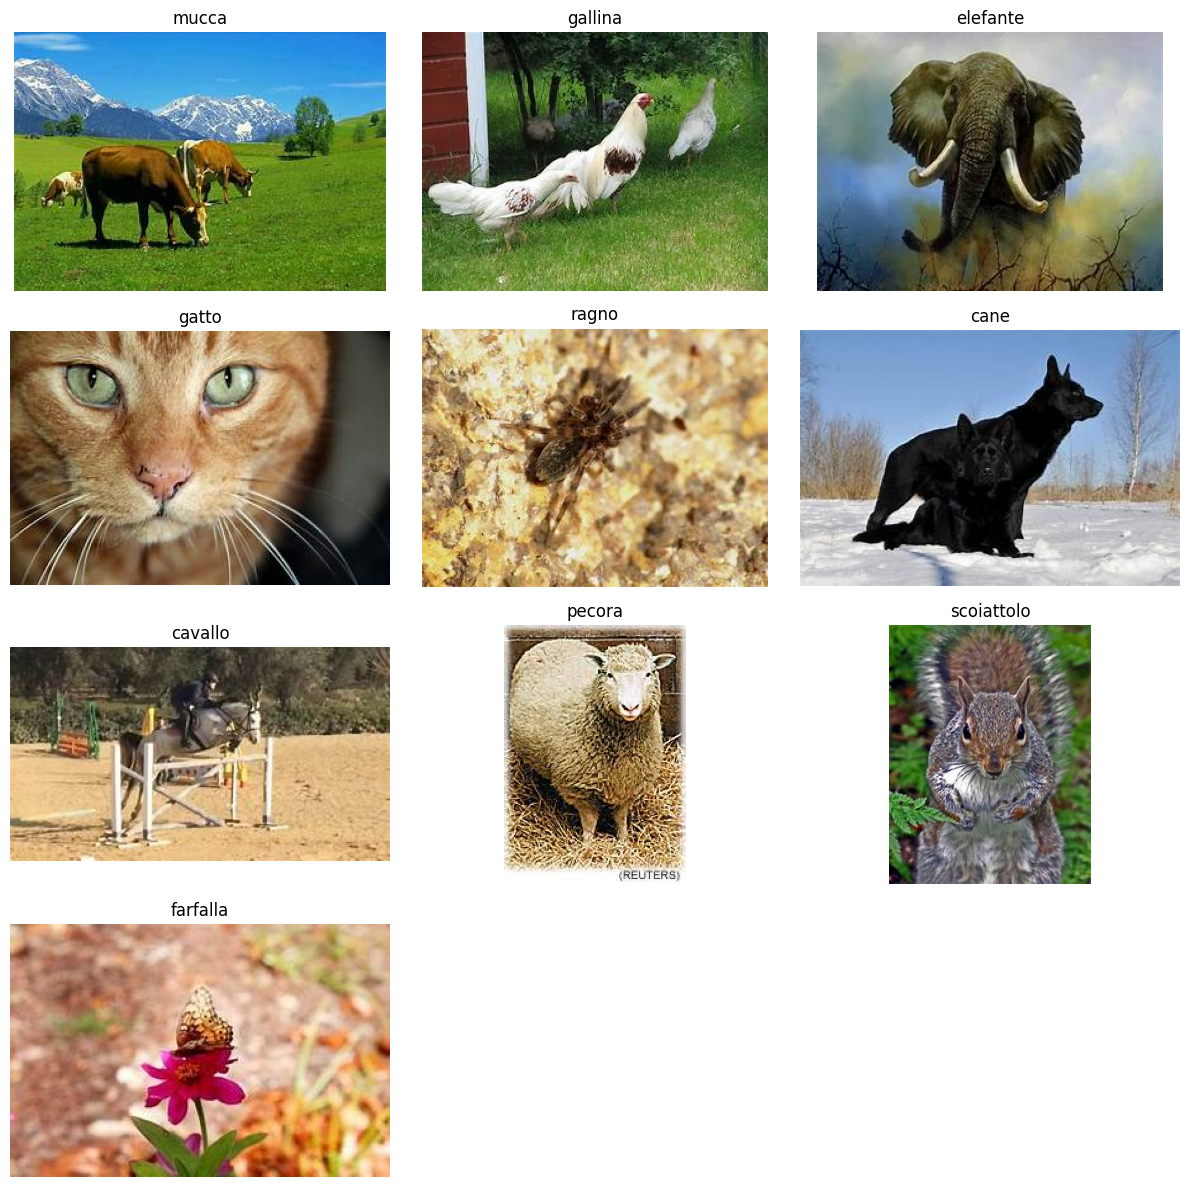

In [43]:
n_animales = len(animales_show)


fig, axes = plt.subplots(4, 3, figsize=(12, 12))  


axes = axes.flatten()

for i, (nombre, ruta) in enumerate(animales_show.items()):
    if i >= 10:
        break  # solo mostramos hasta 10imágenes 1 por cada clase.
    img = Image.open(ruta)
    
    axes[i].imshow(img)
    axes[i].set_title(nombre, fontsize=12)
    axes[i].axis('off')
    
    
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# **PROCESAMIENTO**

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


data_dir = 'raw-img'

dataset = image_dataset_from_directory(
    data_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=True
)

Found 26179 files belonging to 10 classes.


In [45]:
for img, labels in dataset.take(1):
    print("Shape del batch de imágenes:", img.shape)  # (32, 224, 224, 3)
    print("Shape de las etiquetas:", labels.shape)  

Shape del batch de imágenes: (32, 224, 224, 3)
Shape de las etiquetas: (32,)


['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


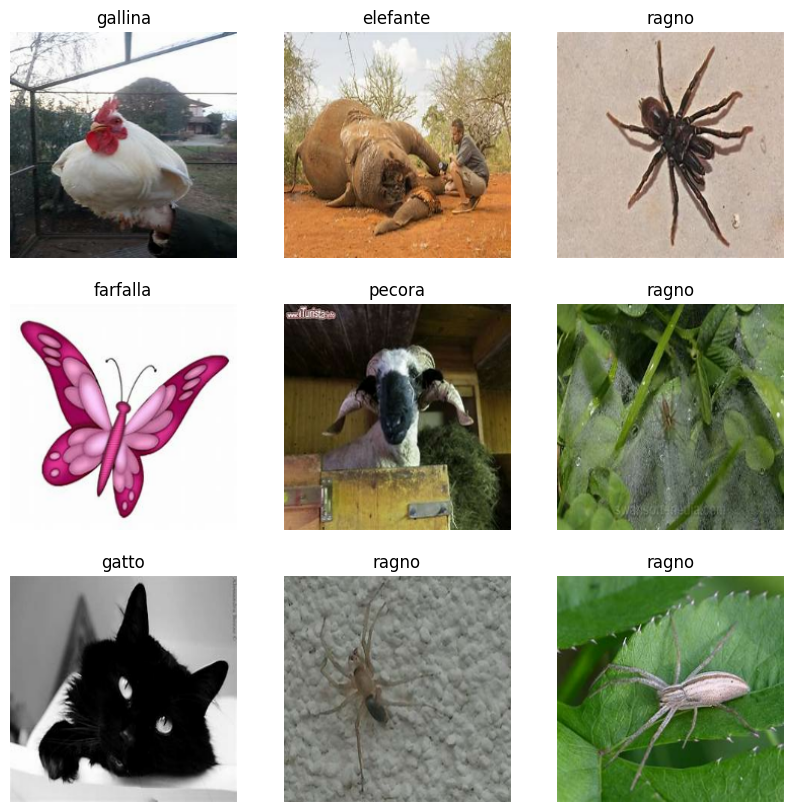

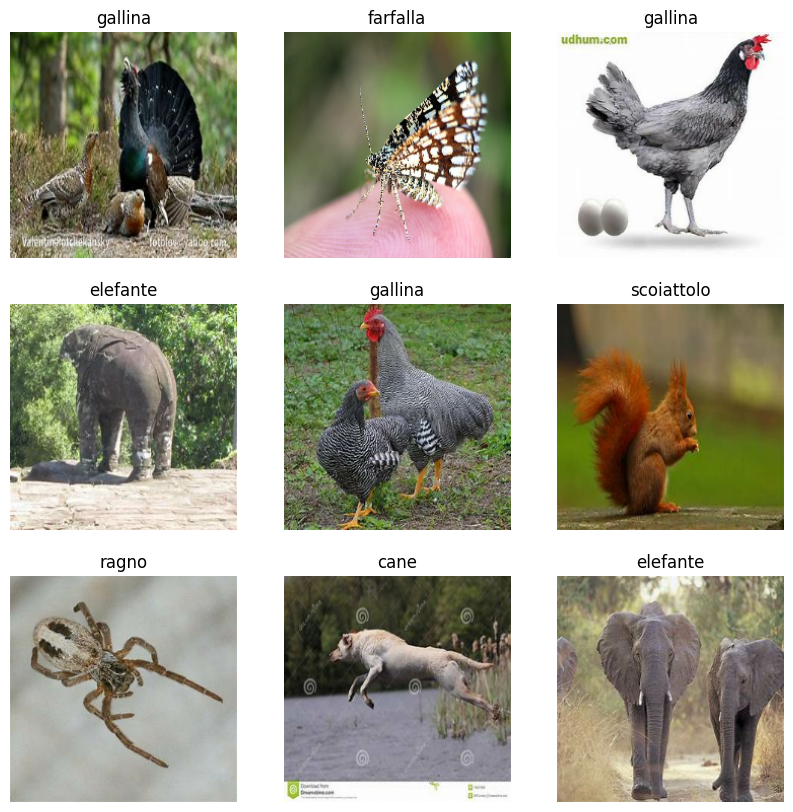

In [46]:


class_names = dataset.class_names

print(class_names)

for img, labels in dataset.take(2):
    
    plt.figure(figsize=(10, 10))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i].numpy()])      # mostrar el nombre de la clase
        plt.axis("off")

In [47]:
from tensorflow.keras.layers import Rescaling


capa_normalizadora = Rescaling(1./255)

# Toma img, label aplicando solo a la imágen la normalizacion y obteniendo la imágen normalizada
normalized_ds = dataset.map(lambda x, y: (capa_normalizadora(x), y))


In [48]:
for imagen, _ in normalized_ds.take(1):
    print("Mínimo:", imagen.numpy().min())
    print("Máximo:", imagen.numpy().max())

Mínimo: 0.0
Máximo: 1.0


# Data Augmentation

In [49]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Para mejorar el poder predictivo y generalización de los datos y evitar el overfitting se generara una data augmentation con flip horizontal, rotando y además con zoom. La idea es que esto ayde al modelo a aprender de los datos más que a memorizarlos


## **Vista general de la data augmentation**

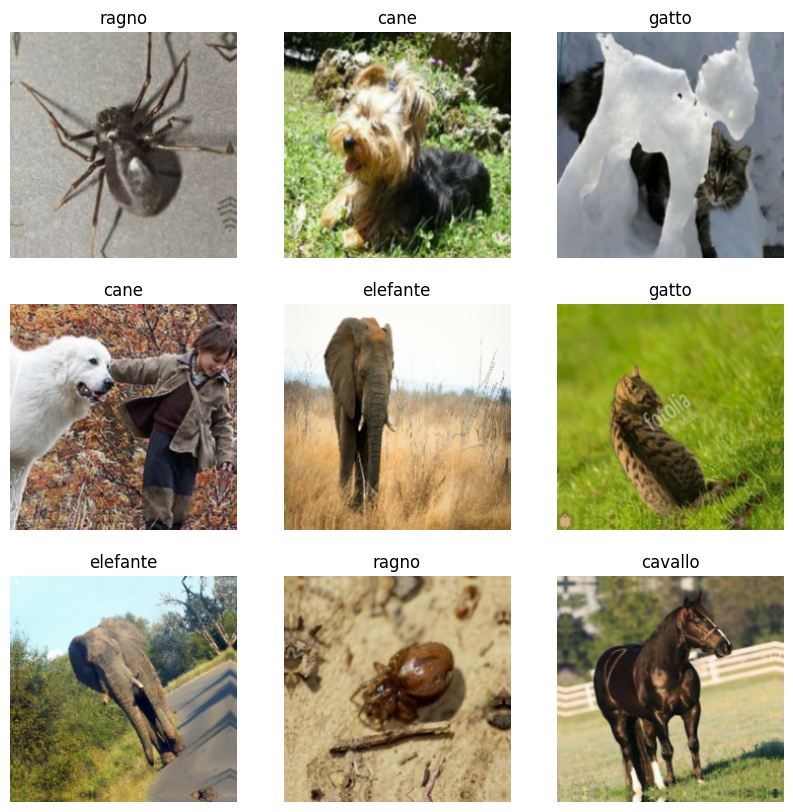

In [59]:
import matplotlib.pyplot as plt


# Vamos a tomar la primera imágen de cada clase
for images, _ in dataset.take(1):
    
    # Aplicamos la augmentation
    augmented_images = data_augmentation(images)
    
    
    
    # Graficamos
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(class_names[_[i].numpy()])
        plt.axis("off")
    break


## **DIVISION - AUGMENTATION - NORMALIZACION**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

data_dir = "raw-img"
batch_size = 32
img_size = (224, 224)

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,   
    subset="training",
    seed=123,                  
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
class_names = train_ds.class_names
print("Clases:", class_names)



Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Clases: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [61]:
from tensorflow.keras.layers import Rescaling
from tensorflow.keras import layers

normalization_layer = Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


# Aplicar aumento y normalización al conjunto de entrenamiento
train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x)), y))

# Aplicar solo normalización al conjunto de validación
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [62]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Método que ayuda un dataset para mejorar el rendimiento del entrenamiento. Este le dice a tf que cargue los demás batches en segundo plano, asi cuando se termine de entrenar ya se encuentra el otro en memoria. Reduce el tiempo muerto y aumenta el rendimiento general.

AUTOTUNE permite a TensorFlow elegir automáticamente la mejor cantidad de batches para adelantar.

Se aplica después de map() o de cualquier transformación.

## **Comprobacion tarjeta de video**

In [55]:
import tensorflow as tf
print(tf.__version__)

print(tf.config.list_physical_devices('GPU'))

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Utilizaremos keras cpm 4 capas de convoluciones desde 32 a 256. El input shape se encuentra definido ya por los parámetros utilizados con las imágenes todas en 224x224 y 3 canales. Utilizamos relu despues de cada convolución para captar la no linerealidad de los datos como asi capas maxpoling para reducir el feature map producido por las convoluciones. Por ultimo realizamos un aplanado de los datos para ser conectados por la capa totalmente conectada con 256 neuronas. Utilizamos softmax como activación para generar nuestras predicciones

In [ ]:
from tensorflow.keras import layers, models

num_classes = len(class_names) # Som 10 

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # ayuda a prevenir overfitting
    layers.Dense(num_classes, activation='softmax')
])


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # porque usamos etiquetas como enteros
    metrics=['accuracy']
)       


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    
)

Epoch 1/10


2025-06-15 18:21:51.656791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/655 [=>............................] - ETA: 1:16 - loss: 2.2736 - accuracy: 0.1875

2025-06-15 18:21:58.844383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/655 [===>..........................] - ETA: 1:13 - loss: 2.2451 - accuracy: 0.1933

2025-06-15 18:22:03.725585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/655 [=====>........................] - ETA: 1:07 - loss: 2.2339 - accuracy: 0.2016

2025-06-15 18:22:09.478775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/655 [=====>........................] - ETA: 1:05 - loss: 2.2306 - accuracy: 0.2021

2025-06-15 18:22:11.189226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/655 [======>.......................] - ETA: 1:05 - loss: 2.2253 - accuracy: 0.2048

2025-06-15 18:22:12.105177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/655 [=======>......................] - ETA: 1:02 - loss: 2.2156 - accuracy: 0.2057

2025-06-15 18:22:15.462101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/655 [========>.....................] - ETA: 59s - loss: 2.2031 - accuracy: 0.2124

2025-06-15 18:22:18.549256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/655 [==========>...................] - ETA: 52s - loss: 2.1700 - accuracy: 0.2289

2025-06-15 18:22:25.787815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/655 [============>.................] - ETA: 46s - loss: 2.1495 - accuracy: 0.2369

2025-06-15 18:22:31.005420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


354/655 [===============>..............] - ETA: 39s - loss: 2.1199 - accuracy: 0.2495

2025-06-15 18:22:38.519907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


440/655 [===================>..........] - ETA: 28s - loss: 2.0727 - accuracy: 0.2692

2025-06-15 18:22:49.680132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


487/655 [=====================>........] - ETA: 22s - loss: 2.0506 - accuracy: 0.2779

2025-06-15 18:22:55.903512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


490/655 [=====================>........] - ETA: 21s - loss: 2.0494 - accuracy: 0.2784

2025-06-15 18:22:56.324432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


504/655 [======================>.......] - ETA: 19s - loss: 2.0415 - accuracy: 0.2818

2025-06-15 18:22:58.270698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


520/655 [======================>.......] - ETA: 17s - loss: 2.0373 - accuracy: 0.2833

2025-06-15 18:23:00.356728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


557/655 [========================>.....] - ETA: 12s - loss: 2.0226 - accuracy: 0.2880

2025-06-15 18:23:05.221781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


606/655 [==========================>...] - ETA: 6s - loss: 2.0039 - accuracy: 0.2950

2025-06-15 18:23:11.646749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - ETA: 0s - loss: 1.9888 - accuracy: 0.3004

2025-06-15 18:23:18.354820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:23:18.496691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:23:18.708464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:23:20.337506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - 90s 136ms/step - loss: 1.9888 - accuracy: 0.3004 - val_loss: 1.8751 - val_accuracy: 0.3578
Epoch 2/10


2025-06-15 18:23:21.297683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/655 [=>............................] - ETA: 1:20 - loss: 1.7664 - accuracy: 0.3767

2025-06-15 18:23:28.413869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/655 [===>..........................] - ETA: 1:16 - loss: 1.7662 - accuracy: 0.3767

2025-06-15 18:23:33.449360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/655 [=====>........................] - ETA: 1:09 - loss: 1.7440 - accuracy: 0.3822

2025-06-15 18:23:39.161915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/655 [=====>........................] - ETA: 1:07 - loss: 1.7465 - accuracy: 0.3843

2025-06-15 18:23:40.802799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/655 [======>.......................] - ETA: 1:06 - loss: 1.7394 - accuracy: 0.3879

2025-06-15 18:23:41.753815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/655 [=======>......................] - ETA: 1:03 - loss: 1.7353 - accuracy: 0.3891

2025-06-15 18:23:44.939429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/655 [========>.....................] - ETA: 1:00 - loss: 1.7264 - accuracy: 0.3956

2025-06-15 18:23:48.148563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/655 [==========>...................] - ETA: 52s - loss: 1.7188 - accuracy: 0.3991

2025-06-15 18:23:55.147020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/655 [============>.................] - ETA: 47s - loss: 1.7062 - accuracy: 0.4049

2025-06-15 18:24:00.456916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


354/655 [===============>..............] - ETA: 39s - loss: 1.6880 - accuracy: 0.4108

2025-06-15 18:24:07.979653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


440/655 [===================>..........] - ETA: 28s - loss: 1.6636 - accuracy: 0.4212

2025-06-15 18:24:19.045981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


487/655 [=====================>........] - ETA: 22s - loss: 1.6479 - accuracy: 0.4262

2025-06-15 18:24:25.162640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


490/655 [=====================>........] - ETA: 21s - loss: 1.6468 - accuracy: 0.4265

2025-06-15 18:24:25.551221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


504/655 [======================>.......] - ETA: 19s - loss: 1.6431 - accuracy: 0.4280

2025-06-15 18:24:27.380364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


520/655 [======================>.......] - ETA: 17s - loss: 1.6403 - accuracy: 0.4287

2025-06-15 18:24:29.455536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


557/655 [========================>.....] - ETA: 12s - loss: 1.6347 - accuracy: 0.4312

2025-06-15 18:24:34.576083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


606/655 [==========================>...] - ETA: 6s - loss: 1.6249 - accuracy: 0.4351

2025-06-15 18:24:41.087084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - ETA: 0s - loss: 1.6199 - accuracy: 0.4373

2025-06-15 18:24:47.467048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:24:47.598794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:24:47.810455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:24:49.426127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - 89s 136ms/step - loss: 1.6199 - accuracy: 0.4373 - val_loss: 1.3750 - val_accuracy: 0.5368
Epoch 3/10
  1/655 [..............................] - ETA: 3:12 - loss: 1.3154 - accuracy: 0.4688

2025-06-15 18:24:50.341809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/655 [=>............................] - ETA: 1:19 - loss: 1.4635 - accuracy: 0.4988

2025-06-15 18:24:57.349396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/655 [===>..........................] - ETA: 1:14 - loss: 1.4899 - accuracy: 0.4914

2025-06-15 18:25:02.173133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/655 [=====>........................] - ETA: 1:08 - loss: 1.5007 - accuracy: 0.4833

2025-06-15 18:25:07.994726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/655 [=====>........................] - ETA: 1:06 - loss: 1.5019 - accuracy: 0.4831

2025-06-15 18:25:09.716531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/655 [======>.......................] - ETA: 1:05 - loss: 1.5046 - accuracy: 0.4812

2025-06-15 18:25:10.642324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/655 [=======>......................] - ETA: 1:02 - loss: 1.5058 - accuracy: 0.4797

2025-06-15 18:25:13.806000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/655 [========>.....................] - ETA: 59s - loss: 1.4979 - accuracy: 0.4826

2025-06-15 18:25:16.966789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/655 [==========>...................] - ETA: 52s - loss: 1.4922 - accuracy: 0.4839

2025-06-15 18:25:24.142754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/655 [============>.................] - ETA: 46s - loss: 1.4824 - accuracy: 0.4889

2025-06-15 18:25:29.431117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


354/655 [===============>..............] - ETA: 39s - loss: 1.4717 - accuracy: 0.4922

2025-06-15 18:25:36.745132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


440/655 [===================>..........] - ETA: 28s - loss: 1.4563 - accuracy: 0.4989

2025-06-15 18:25:48.118049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


487/655 [=====================>........] - ETA: 22s - loss: 1.4457 - accuracy: 0.5024

2025-06-15 18:25:54.285095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


490/655 [=====================>........] - ETA: 21s - loss: 1.4453 - accuracy: 0.5027

2025-06-15 18:25:54.662162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


504/655 [======================>.......] - ETA: 19s - loss: 1.4424 - accuracy: 0.5043

2025-06-15 18:25:56.442550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


520/655 [======================>.......] - ETA: 17s - loss: 1.4440 - accuracy: 0.5039

2025-06-15 18:25:58.467050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


557/655 [========================>.....] - ETA: 12s - loss: 1.4364 - accuracy: 0.5074

2025-06-15 18:26:03.369515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


606/655 [==========================>...] - ETA: 6s - loss: 1.4285 - accuracy: 0.5102

2025-06-15 18:26:09.767949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - ETA: 0s - loss: 1.4266 - accuracy: 0.5109

2025-06-15 18:26:16.158757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:26:16.296836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:26:16.528502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:26:18.222775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - 89s 135ms/step - loss: 1.4266 - accuracy: 0.5109 - val_loss: 1.2324 - val_accuracy: 0.5801
Epoch 4/10
  1/655 [..............................] - ETA: 3:18 - loss: 1.4761 - accuracy: 0.5312

2025-06-15 18:26:19.192934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/655 [=>............................] - ETA: 1:20 - loss: 1.2859 - accuracy: 0.5637

2025-06-15 18:26:26.332338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/655 [===>..........................] - ETA: 1:15 - loss: 1.3235 - accuracy: 0.5570

2025-06-15 18:26:31.301822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/655 [=====>........................] - ETA: 1:09 - loss: 1.3315 - accuracy: 0.5514

2025-06-15 18:26:37.104003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/655 [=====>........................] - ETA: 1:07 - loss: 1.3325 - accuracy: 0.5488

2025-06-15 18:26:38.821656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/655 [======>.......................] - ETA: 1:06 - loss: 1.3318 - accuracy: 0.5478

2025-06-15 18:26:39.724803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/655 [=======>......................] - ETA: 1:03 - loss: 1.3329 - accuracy: 0.5484

2025-06-15 18:26:42.844169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/655 [========>.....................] - ETA: 59s - loss: 1.3311 - accuracy: 0.5500 

2025-06-15 18:26:45.987913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/655 [==========>...................] - ETA: 52s - loss: 1.3210 - accuracy: 0.5492

2025-06-15 18:26:53.211885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/655 [============>.................] - ETA: 47s - loss: 1.3152 - accuracy: 0.5513

2025-06-15 18:26:58.377084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


354/655 [===============>..............] - ETA: 39s - loss: 1.3124 - accuracy: 0.5520

2025-06-15 18:27:05.574338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


440/655 [===================>..........] - ETA: 28s - loss: 1.2919 - accuracy: 0.5605

2025-06-15 18:27:17.027630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


487/655 [=====================>........] - ETA: 22s - loss: 1.2837 - accuracy: 0.5629

2025-06-15 18:27:23.248892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


490/655 [=====================>........] - ETA: 21s - loss: 1.2819 - accuracy: 0.5635

2025-06-15 18:27:23.637634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


504/655 [======================>.......] - ETA: 19s - loss: 1.2782 - accuracy: 0.5647

2025-06-15 18:27:25.508843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


520/655 [======================>.......] - ETA: 17s - loss: 1.2785 - accuracy: 0.5648

2025-06-15 18:27:27.671054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


557/655 [========================>.....] - ETA: 12s - loss: 1.2765 - accuracy: 0.5672

2025-06-15 18:27:32.643680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


606/655 [==========================>...] - ETA: 6s - loss: 1.2718 - accuracy: 0.5684

2025-06-15 18:27:39.039629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - ETA: 0s - loss: 1.2739 - accuracy: 0.5681

2025-06-15 18:27:45.775677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:27:45.903800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:27:46.122986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:27:47.741694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - 89s 136ms/step - loss: 1.2739 - accuracy: 0.5681 - val_loss: 1.2473 - val_accuracy: 0.5773
Epoch 5/10
  1/655 [..............................] - ETA: 3:12 - loss: 1.4631 - accuracy: 0.4062

2025-06-15 18:27:48.645664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/655 [=>............................] - ETA: 1:22 - loss: 1.2249 - accuracy: 0.5972

2025-06-15 18:27:55.912230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/655 [===>..........................] - ETA: 1:16 - loss: 1.2387 - accuracy: 0.5893

2025-06-15 18:28:00.890264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/655 [=====>........................] - ETA: 1:10 - loss: 1.2164 - accuracy: 0.5963

2025-06-15 18:28:06.715686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/655 [=====>........................] - ETA: 1:08 - loss: 1.2187 - accuracy: 0.5923

2025-06-15 18:28:08.424129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/655 [======>.......................] - ETA: 1:07 - loss: 1.2230 - accuracy: 0.5913

2025-06-15 18:28:09.396838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/655 [=======>......................] - ETA: 1:03 - loss: 1.2361 - accuracy: 0.5866

2025-06-15 18:28:12.469495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/655 [========>.....................] - ETA: 1:00 - loss: 1.2318 - accuracy: 0.5861

2025-06-15 18:28:15.534348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/655 [==========>...................] - ETA: 52s - loss: 1.2274 - accuracy: 0.5878

2025-06-15 18:28:22.830947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/655 [============>.................] - ETA: 47s - loss: 1.2251 - accuracy: 0.5911

2025-06-15 18:28:28.072846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


354/655 [===============>..............] - ETA: 39s - loss: 1.2256 - accuracy: 0.5908

2025-06-15 18:28:35.565721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


440/655 [===================>..........] - ETA: 28s - loss: 1.2176 - accuracy: 0.5950

2025-06-15 18:28:46.836372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


487/655 [=====================>........] - ETA: 22s - loss: 1.2128 - accuracy: 0.5965

2025-06-15 18:28:53.036735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


490/655 [=====================>........] - ETA: 21s - loss: 1.2109 - accuracy: 0.5973

2025-06-15 18:28:53.415099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


504/655 [======================>.......] - ETA: 19s - loss: 1.2096 - accuracy: 0.5975

2025-06-15 18:28:55.182333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


520/655 [======================>.......] - ETA: 17s - loss: 1.2067 - accuracy: 0.5979

2025-06-15 18:28:57.287644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


557/655 [========================>.....] - ETA: 12s - loss: 1.2032 - accuracy: 0.5999

2025-06-15 18:29:02.191824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


606/655 [==========================>...] - ETA: 6s - loss: 1.2016 - accuracy: 0.5992

2025-06-15 18:29:08.745481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - ETA: 0s - loss: 1.1983 - accuracy: 0.5999

2025-06-15 18:29:15.336332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:29:15.468832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:29:15.681481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:29:17.322301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - 90s 137ms/step - loss: 1.1983 - accuracy: 0.5999 - val_loss: 1.1126 - val_accuracy: 0.6139
Epoch 6/10
  1/655 [..............................] - ETA: 3:11 - loss: 1.0775 - accuracy: 0.6250

2025-06-15 18:29:18.277672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/655 [=>............................] - ETA: 1:20 - loss: 1.1286 - accuracy: 0.6221

2025-06-15 18:29:25.387598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/655 [===>..........................] - ETA: 1:15 - loss: 1.1401 - accuracy: 0.6171

2025-06-15 18:29:30.308953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/655 [=====>........................] - ETA: 1:09 - loss: 1.1392 - accuracy: 0.6204

2025-06-15 18:29:36.109959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/655 [=====>........................] - ETA: 1:07 - loss: 1.1424 - accuracy: 0.6193

2025-06-15 18:29:37.808951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/655 [======>.......................] - ETA: 1:06 - loss: 1.1399 - accuracy: 0.6198

2025-06-15 18:29:38.691590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/655 [=======>......................] - ETA: 1:03 - loss: 1.1532 - accuracy: 0.6152

2025-06-15 18:29:41.867006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/655 [========>.....................] - ETA: 59s - loss: 1.1519 - accuracy: 0.6151

2025-06-15 18:29:44.938310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/655 [==========>...................] - ETA: 52s - loss: 1.1503 - accuracy: 0.6125

2025-06-15 18:29:52.303217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


297/655 [============>.................] - ETA: 47s - loss: 1.1401 - accuracy: 0.6146

2025-06-15 18:29:57.390073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


354/655 [===============>..............] - ETA: 39s - loss: 1.1392 - accuracy: 0.6120

2025-06-15 18:30:04.705442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


440/655 [===================>..........] - ETA: 28s - loss: 1.1304 - accuracy: 0.6153

2025-06-15 18:30:15.846917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


487/655 [=====================>........] - ETA: 22s - loss: 1.1309 - accuracy: 0.6154

2025-06-15 18:30:22.068447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


490/655 [=====================>........] - ETA: 21s - loss: 1.1299 - accuracy: 0.6158

2025-06-15 18:30:22.446044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


504/655 [======================>.......] - ETA: 19s - loss: 1.1275 - accuracy: 0.6168

2025-06-15 18:30:24.293332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


520/655 [======================>.......] - ETA: 17s - loss: 1.1240 - accuracy: 0.6184

2025-06-15 18:30:26.397464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


557/655 [========================>.....] - ETA: 12s - loss: 1.1218 - accuracy: 0.6200

2025-06-15 18:30:31.180155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


606/655 [==========================>...] - ETA: 6s - loss: 1.1192 - accuracy: 0.6200

2025-06-15 18:30:37.476800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - ETA: 0s - loss: 1.1214 - accuracy: 0.6196

2025-06-15 18:30:44.100555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:30:44.236202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:30:44.445463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:30:46.054466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - 89s 135ms/step - loss: 1.1214 - accuracy: 0.6196 - val_loss: 1.0170 - val_accuracy: 0.6623
Epoch 7/10
  1/655 [..............................] - ETA: 3:09 - loss: 0.8770 - accuracy: 0.6875

2025-06-15 18:30:46.941524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/655 [=>............................] - ETA: 1:22 - loss: 1.0701 - accuracy: 0.6400

2025-06-15 18:30:54.203784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/655 [===>..........................] - ETA: 1:16 - loss: 1.0734 - accuracy: 0.6384

2025-06-15 18:30:59.100049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/655 [=====>........................] - ETA: 1:09 - loss: 1.0644 - accuracy: 0.6398

2025-06-15 18:31:04.861342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/655 [=====>........................] - ETA: 1:07 - loss: 1.0695 - accuracy: 0.6398

2025-06-15 18:31:06.592209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/655 [======>.......................] - ETA: 1:06 - loss: 1.0730 - accuracy: 0.6393

2025-06-15 18:31:07.483444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/655 [=======>......................] - ETA: 1:03 - loss: 1.0826 - accuracy: 0.6350

2025-06-15 18:31:10.812367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/655 [========>.....................] - ETA: 1:00 - loss: 1.0796 - accuracy: 0.6375

2025-06-15 18:31:13.957256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/655 [==========>...................] - ETA: 52s - loss: 1.0837 - accuracy: 0.6381

2025-06-15 18:31:21.167123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/655 [============>.................] - ETA: 47s - loss: 1.0815 - accuracy: 0.6401

2025-06-15 18:31:26.349759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


354/655 [===============>..............] - ETA: 39s - loss: 1.0811 - accuracy: 0.6387

2025-06-15 18:31:33.757332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


440/655 [===================>..........] - ETA: 28s - loss: 1.0775 - accuracy: 0.6393

2025-06-15 18:31:45.161571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


487/655 [=====================>........] - ETA: 22s - loss: 1.0733 - accuracy: 0.6412

2025-06-15 18:31:51.547025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


490/655 [=====================>........] - ETA: 21s - loss: 1.0736 - accuracy: 0.6411

2025-06-15 18:31:51.951237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


504/655 [======================>.......] - ETA: 20s - loss: 1.0703 - accuracy: 0.6422

2025-06-15 18:31:53.678997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


520/655 [======================>.......] - ETA: 17s - loss: 1.0706 - accuracy: 0.6422

2025-06-15 18:31:55.757498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


557/655 [========================>.....] - ETA: 12s - loss: 1.0726 - accuracy: 0.6422

2025-06-15 18:32:00.614067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


606/655 [==========================>...] - ETA: 6s - loss: 1.0664 - accuracy: 0.6434

2025-06-15 18:32:07.194483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - ETA: 0s - loss: 1.0667 - accuracy: 0.6437

2025-06-15 18:32:13.929434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:32:14.066929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:32:14.277577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:32:15.901891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - 90s 137ms/step - loss: 1.0667 - accuracy: 0.6437 - val_loss: 1.0119 - val_accuracy: 0.6602
Epoch 8/10
  1/655 [..............................] - ETA: 3:22 - loss: 0.8824 - accuracy: 0.6875

2025-06-15 18:32:16.836115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/655 [=>............................] - ETA: 1:20 - loss: 1.0160 - accuracy: 0.6782

2025-06-15 18:32:23.940159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/655 [===>..........................] - ETA: 1:13 - loss: 1.0366 - accuracy: 0.6669

2025-06-15 18:32:28.661067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/655 [=====>........................] - ETA: 1:08 - loss: 1.0281 - accuracy: 0.6632

2025-06-15 18:32:34.420498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/655 [=====>........................] - ETA: 1:06 - loss: 1.0300 - accuracy: 0.6624

2025-06-15 18:32:36.068517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/655 [======>.......................] - ETA: 1:05 - loss: 1.0354 - accuracy: 0.6599

2025-06-15 18:32:36.970071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/655 [=======>......................] - ETA: 1:02 - loss: 1.0497 - accuracy: 0.6515

2025-06-15 18:32:40.073213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/655 [========>.....................] - ETA: 58s - loss: 1.0507 - accuracy: 0.6502

2025-06-15 18:32:43.147559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/655 [==========>...................] - ETA: 51s - loss: 1.0439 - accuracy: 0.6521

2025-06-15 18:32:50.236547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/655 [============>.................] - ETA: 46s - loss: 1.0408 - accuracy: 0.6536

2025-06-15 18:32:55.318379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


354/655 [===============>..............] - ETA: 39s - loss: 1.0435 - accuracy: 0.6549

2025-06-15 18:33:02.682775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


440/655 [===================>..........] - ETA: 27s - loss: 1.0390 - accuracy: 0.6567

2025-06-15 18:33:13.736964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


487/655 [=====================>........] - ETA: 21s - loss: 1.0344 - accuracy: 0.6565

2025-06-15 18:33:19.919294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


490/655 [=====================>........] - ETA: 21s - loss: 1.0333 - accuracy: 0.6572

2025-06-15 18:33:20.316018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


504/655 [======================>.......] - ETA: 19s - loss: 1.0332 - accuracy: 0.6566

2025-06-15 18:33:22.223414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


520/655 [======================>.......] - ETA: 17s - loss: 1.0326 - accuracy: 0.6572

2025-06-15 18:33:24.297326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


557/655 [========================>.....] - ETA: 12s - loss: 1.0299 - accuracy: 0.6583

2025-06-15 18:33:29.179795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


606/655 [==========================>...] - ETA: 6s - loss: 1.0247 - accuracy: 0.6588

2025-06-15 18:33:35.603901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - ETA: 0s - loss: 1.0284 - accuracy: 0.6582

2025-06-15 18:33:42.199089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:33:42.314347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:33:42.531010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:33:44.157607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - 88s 134ms/step - loss: 1.0284 - accuracy: 0.6582 - val_loss: 0.9517 - val_accuracy: 0.6825
Epoch 9/10
  1/655 [..............................] - ETA: 3:04 - loss: 1.0411 - accuracy: 0.5938

2025-06-15 18:33:45.046081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/655 [=>............................] - ETA: 1:18 - loss: 0.9740 - accuracy: 0.6782

2025-06-15 18:33:51.945230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/655 [===>..........................] - ETA: 1:12 - loss: 1.0088 - accuracy: 0.6583

2025-06-15 18:33:56.552044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/655 [=====>........................] - ETA: 1:07 - loss: 0.9927 - accuracy: 0.6639

2025-06-15 18:34:02.430533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/655 [=====>........................] - ETA: 1:06 - loss: 0.9973 - accuracy: 0.6615

2025-06-15 18:34:04.185030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/655 [======>.......................] - ETA: 1:05 - loss: 0.9969 - accuracy: 0.6623

2025-06-15 18:34:05.131027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/655 [=======>......................] - ETA: 1:02 - loss: 1.0020 - accuracy: 0.6599

2025-06-15 18:34:08.394838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/655 [========>.....................] - ETA: 59s - loss: 1.0021 - accuracy: 0.6610

2025-06-15 18:34:11.522468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/655 [==========>...................] - ETA: 52s - loss: 0.9969 - accuracy: 0.6611

2025-06-15 18:34:18.768248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/655 [============>.................] - ETA: 46s - loss: 0.9971 - accuracy: 0.6613

2025-06-15 18:34:24.047831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


354/655 [===============>..............] - ETA: 39s - loss: 0.9934 - accuracy: 0.6629

2025-06-15 18:34:31.248563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


440/655 [===================>..........] - ETA: 28s - loss: 0.9912 - accuracy: 0.6640

2025-06-15 18:34:42.425620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


487/655 [=====================>........] - ETA: 21s - loss: 0.9857 - accuracy: 0.6665

2025-06-15 18:34:48.420460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


490/655 [=====================>........] - ETA: 21s - loss: 0.9848 - accuracy: 0.6670

2025-06-15 18:34:48.812871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


504/655 [======================>.......] - ETA: 19s - loss: 0.9836 - accuracy: 0.6673

2025-06-15 18:34:50.614553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


520/655 [======================>.......] - ETA: 17s - loss: 0.9824 - accuracy: 0.6678

2025-06-15 18:34:52.743333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


557/655 [========================>.....] - ETA: 12s - loss: 0.9826 - accuracy: 0.6686

2025-06-15 18:34:57.550814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


605/655 [==========================>...] - ETA: 6s - loss: 0.9800 - accuracy: 0.6698

2025-06-15 18:35:03.911036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - ETA: 0s - loss: 0.9838 - accuracy: 0.6688

2025-06-15 18:35:10.417223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:35:10.566341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:35:10.764072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:35:12.416856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - 88s 135ms/step - loss: 0.9838 - accuracy: 0.6688 - val_loss: 0.9485 - val_accuracy: 0.6810
Epoch 10/10
  1/655 [..............................] - ETA: 3:15 - loss: 1.0815 - accuracy: 0.6875

2025-06-15 18:35:13.347161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/655 [=>............................] - ETA: 1:20 - loss: 0.9591 - accuracy: 0.6834

2025-06-15 18:35:20.496951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/655 [===>..........................] - ETA: 1:13 - loss: 0.9859 - accuracy: 0.6782

2025-06-15 18:35:25.148886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/655 [=====>........................] - ETA: 1:08 - loss: 0.9711 - accuracy: 0.6759

2025-06-15 18:35:30.875929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/655 [=====>........................] - ETA: 1:06 - loss: 0.9775 - accuracy: 0.6750

2025-06-15 18:35:32.684800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/655 [======>.......................] - ETA: 1:05 - loss: 0.9794 - accuracy: 0.6736

2025-06-15 18:35:33.575374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/655 [=======>......................] - ETA: 1:02 - loss: 0.9834 - accuracy: 0.6706

2025-06-15 18:35:36.736885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/655 [========>.....................] - ETA: 59s - loss: 0.9878 - accuracy: 0.6664

2025-06-15 18:35:39.859028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/655 [==========>...................] - ETA: 52s - loss: 0.9966 - accuracy: 0.6657

2025-06-15 18:35:47.086489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/655 [============>.................] - ETA: 46s - loss: 0.9896 - accuracy: 0.6672

2025-06-15 18:35:52.236923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


354/655 [===============>..............] - ETA: 39s - loss: 0.9909 - accuracy: 0.6668

2025-06-15 18:35:59.471651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


440/655 [===================>..........] - ETA: 28s - loss: 0.9796 - accuracy: 0.6712

2025-06-15 18:36:10.698266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


487/655 [=====================>........] - ETA: 21s - loss: 0.9752 - accuracy: 0.6738

2025-06-15 18:36:16.898620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


490/655 [=====================>........] - ETA: 21s - loss: 0.9746 - accuracy: 0.6739

2025-06-15 18:36:17.292767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


504/655 [======================>.......] - ETA: 19s - loss: 0.9753 - accuracy: 0.6734

2025-06-15 18:36:19.112088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


520/655 [======================>.......] - ETA: 17s - loss: 0.9747 - accuracy: 0.6732

2025-06-15 18:36:21.157459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


557/655 [========================>.....] - ETA: 12s - loss: 0.9706 - accuracy: 0.6752

2025-06-15 18:36:25.850598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


606/655 [==========================>...] - ETA: 6s - loss: 0.9693 - accuracy: 0.6756

2025-06-15 18:36:32.260455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


654/655 [============================>.] - ETA: 0s - loss: 0.9686 - accuracy: 0.6750

2025-06-15 18:36:38.895275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:36:39.022068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:36:39.230675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:36:40.841994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - 88s 135ms/step - loss: 0.9688 - accuracy: 0.6748 - val_loss: 0.9846 - val_accuracy: 0.6693


# Analizando el entrenamiento

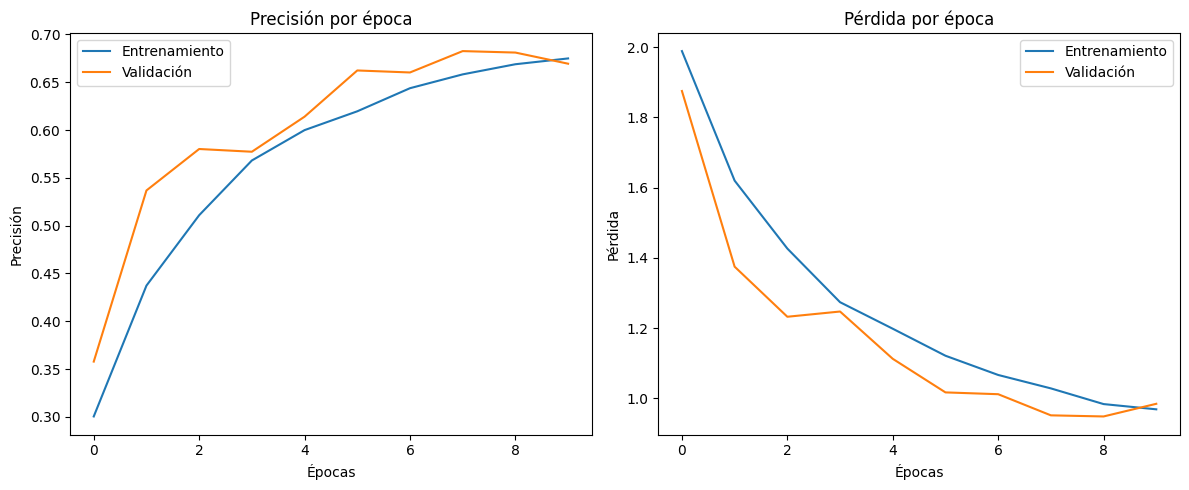

In [63]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()


plt.tight_layout()
plt.show()



### **Precisión por epoca**

A lo largo de las 10 epocas se observa un alza constante en la precision del modelo. La validación siempre se encuentra por sobre el entrenamiento lo que es bueno indicando que el modelo se desempeña mejor con los datos que no son de entrenamiento y por ende con los datos que son "más faciles" debido a que estos no tienen data agumentation. Otra aspecto interesante es que la curva de la validación comienza a disminuir entre la epoca 6-7 dsinisminuyendo para llegar a un "plateu" o para seguir disminuyendo sin poder saberlo debido a que solo se entreno 10 epocas pero podria ser un signo que el entrenamiento tendrá mejor score a mayores epocas generando overfitting.

### **Pérdida por época**

Por otro lado el modelo muestra una consistente disminución en el loss lo que es bastante bueno ya que estamos buscando que la funcion de costo se reduzca lo más que se pueda.  Dentro de esta disminución es claro que en general la linea azul del train disminuye de forma más regular que la validación que posee algunas variaciones donde por ejemplo en la epoca 3 aumenta en vez de disminuir y cerca de la epoca 6-7 comienza a aumentar sobrepasando el entrenamiento claro signo de que el modelo está comenzando a memorizar los datos.


### **CONCLUSIÓN**

Según lo revisado tenemos dos opciones optar por trasnfer learning con algún modelo ya entrenado con datas masivos y/o tratar de mejorar un poco nuestros datos ya sea metiendo mas dropout ,kernel regularizer y/o batch normalization para tratar de mitigar el efecto del overfitting a epocas más altas.